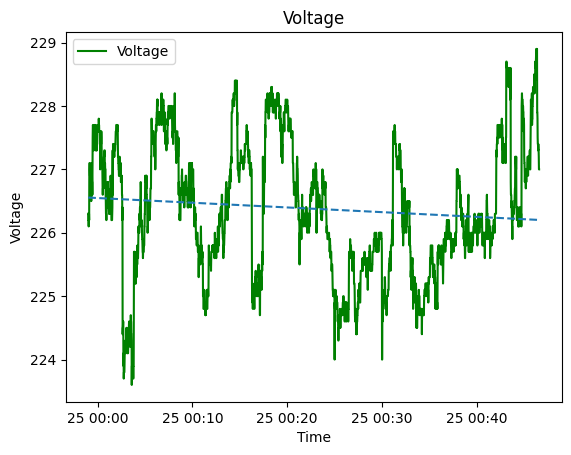

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from datetime import datetime

x = []
y = []
with open("../24-03-2023/serial_data.csv", 'r') as file:
    plots = csv.reader(file)
    is_header = True
    for row in plots:
        if is_header:
            is_header = False
            continue
        if datetime.fromisoformat(row[0]) > datetime.fromisoformat("2023-03-24 23:59:00"):
            continue
        x.append(datetime.fromisoformat(row[0]))
        y.append(float(row[1]))

x_timestamp = np.array(list(map(lambda x : x.timestamp(), x)))
p = np.poly1d(np.polyfit(x_timestamp, y, 1))

plt.plot(x, y, color = 'g', label = "Voltage")
plt.plot(x, p(x_timestamp), linestyle="--")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('Voltage')
plt.legend()
plt.show()

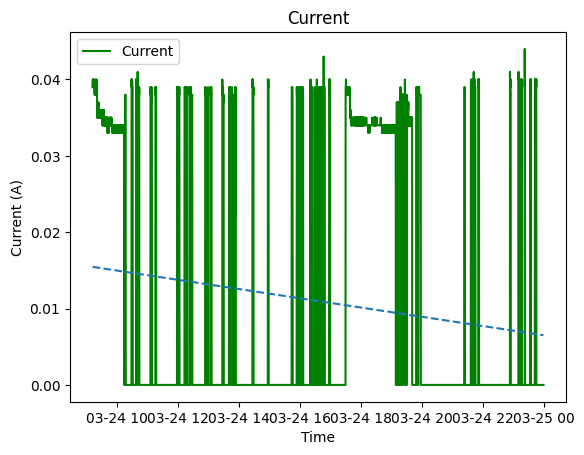

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from datetime import datetime

x = []
y = []
with open("../24-03-2023/serial_data.csv", 'r') as file:
    plots = csv.reader(file)
    is_header = True
    for row in plots:
        if is_header:
            is_header = False
            continue
        if datetime.fromisoformat(row[0]) > datetime.fromisoformat("2023-03-24 23:59:00"):
            continue
        x.append(datetime.fromisoformat(row[0]))
        y.append(float(row[2]))

x_timestamp = np.array(list(map(lambda x: x.timestamp(), x)))
p = np.poly1d(np.polyfit(x_timestamp, y, 1))

plt.plot(x, y, color='g', label="Current")
plt.plot(x, p(x_timestamp), linestyle="--")
plt.xlabel('Time')
plt.ylabel('Current (A)')
plt.title('Current')
plt.legend()
plt.show()


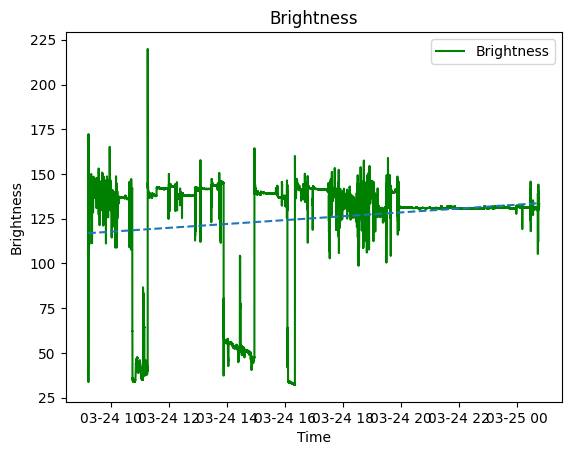

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from datetime import datetime

x = []
y = []
with open("../24-03-2023/brightness_data.csv", 'r') as file:
    plots = csv.reader(file)
    is_header = True
    for row in plots:
        if is_header:
            is_header = False
            continue
        x.append(datetime.fromisoformat(row[0]))
        y.append(float(row[1]))

x_timestamp = np.array(list(map(lambda x : x.timestamp(), x)))
p = np.poly1d(np.polyfit(x_timestamp, y, 1))

plt.plot(x, y, color = 'g', label = "Brightness")
plt.plot(x, p(x_timestamp), linestyle="--")
plt.xlabel('Time')
plt.ylabel('Brightness')
plt.title('Brightness')
plt.legend()
plt.show()